# **Simulador "2 Link Planar Robot"**

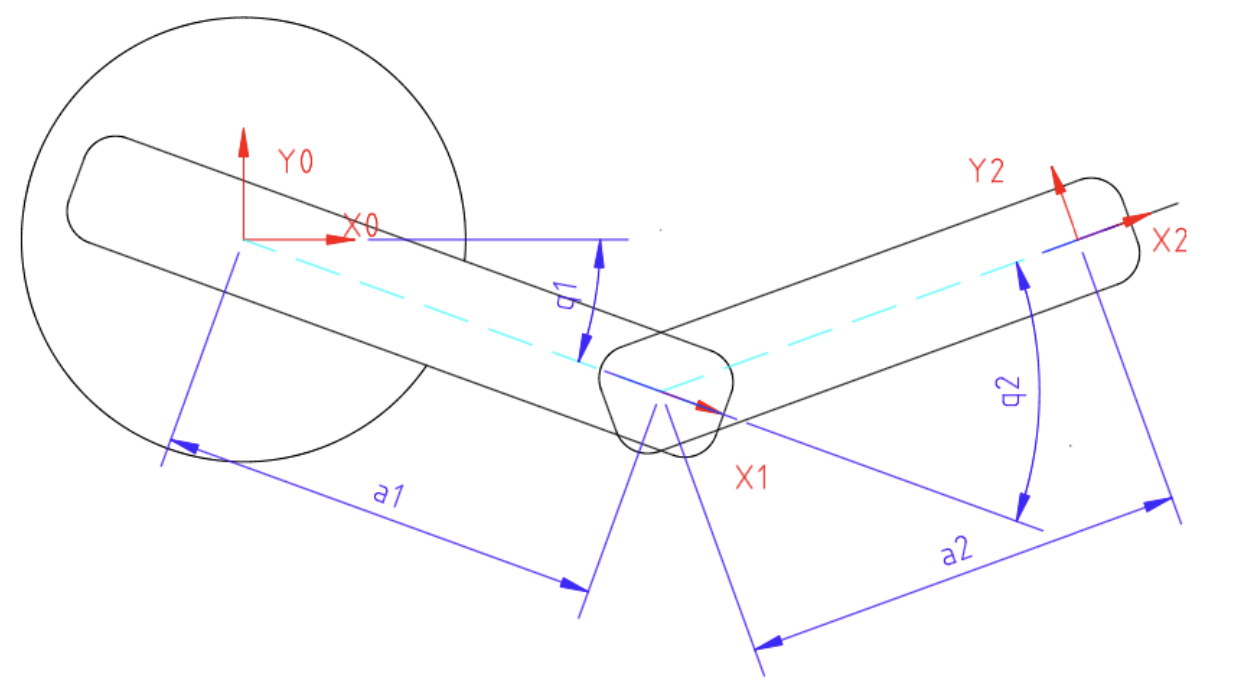


Parámetros de referencia utilizados:
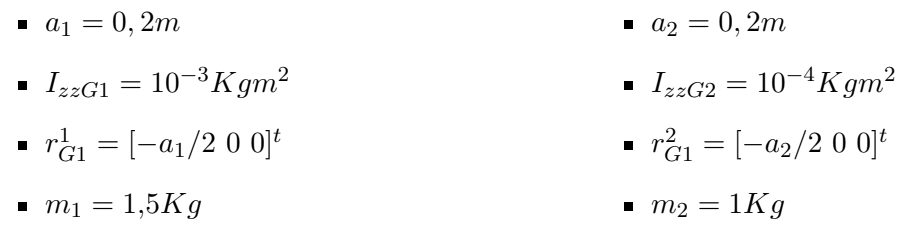


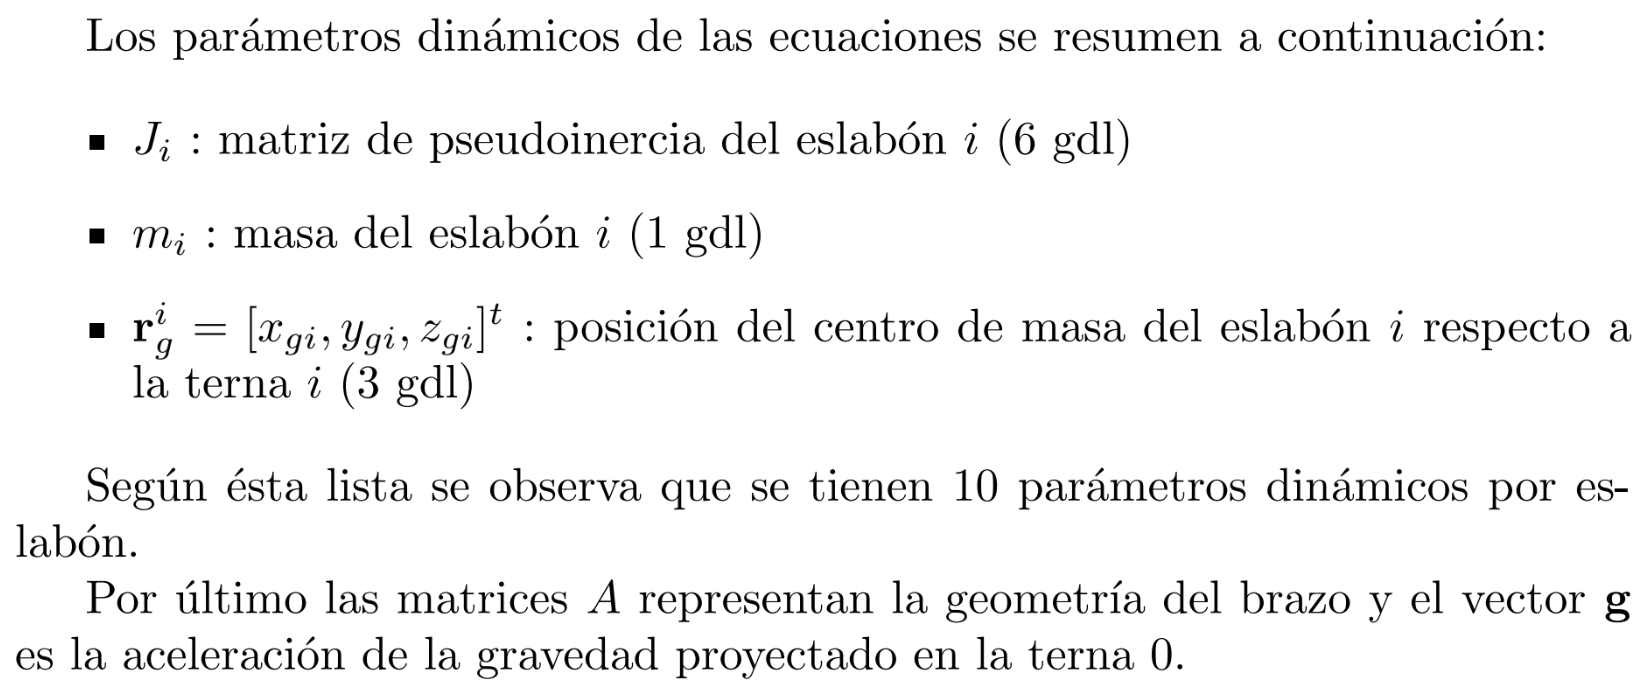

In [1]:
import numpy as np
from sympy import *
import sympy as sp
import time as pytime
from sympy.physics.mechanics import dynamicsymbols
from scipy.integrate import solve_ivp, odeint
from sympy import symbols, lambdify, cos, sin
import matplotlib.pyplot as plt
from tabulate import tabulate
from IPython.display import Markdown, display
from matplotlib.patches import Rectangle, Circle
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D
from IPython.display import HTML
from sympy.physics.vector import init_vprinting
init_vprinting(use_latex='mathjax', pretty_print=False)
#%matplotlib notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'
#'last' -> Hace plot pero muestra animación con plot extra vacío antes
#'last_expr_or_assign' -> No hace plot pero muestra la animacion sin plot extra
#%precision 11
#Presición

In [2]:
import os
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [3]:
import time
from datetime import datetime
fecha_actual = datetime.now().strftime("%Y-%m-%d")

In [4]:
class Robot_2LP:
    def __init__(self, a1, a2, w1=0, w2=0, d1=0, d2=0, theta1=0.0, theta2=0.0, alpha1=0, alpha2=0, cm1=None, cm2=None, in1=0, in2=0, vfr1=0, vfr2=0, sfr1=0, sfr2=0, g_x=0, g_y=-9.81, g_z=0, mm_1=0, mm_2=0, im_1=0, im_2=0):
        self.longs = [a1, a2] #Longitudes de los eslabones en milimetros
        self.dist = [d1, d2] #Distancias entre los ejes (s/ DH)
        self.thetas = [theta1, theta2] #Angulos iniciales en radianes
        self.alphas = [alpha1, alpha2] #Angulos iniciales
        self.masses = [w1, w2] #Masas
        self.num_links = 2
        #Si no se define la pos del centro de masa del eslabon (considerandolo solo longitudinal) se toma el medio
        #El tema es que, nada es solo longitudinal, me va a servir para esto pero si le doy ancho a los eslabones ya no me anda para lo que quiero
        #self.mass_center_l1 = [0,0]
        #self.mass_center_l2 = [0,0]
        self.mass_center = [-a1/2, -a2/2]#En principio voy a asumir que estan a la mitad de cada eslabon
        self.mcp_1 = [self.mass_center_position_self(i=0)]
        self.inertia = [in1, in2] #Valores Inerciales
        #self.vfrict = [vfr1, vfr2] #Valores de friccion viscosa entre articulaciones
        #self.sfrict = [sfr1, sfr2]
        self.gravity = [g_x, g_y, g_z] #Determinada para el eje y negativo

        #Motores!! -> Cada eje tiene un motor asociado para hacer el movimiento
        #En las primeras simulaciones los puedo tomar como 0, pero eventualmente
        #tengo que considerarlos
        self.motor_masses = [mm_1, mm_2]
        self.motor_inertias = [im_1, im_2]

        self.symbolic_constants = {
            sp.symbols('alpha1', real=True): self.alphas[0],
            sp.symbols('alpha2', real=True): self.alphas[1],
            sp.symbols('d1', real=True): self.dist[0],
            sp.symbols('d2', real=True): self.dist[1],
            sp.symbols('a1', real=True): self.longs[0],
            sp.symbols('a2', real=True): self.longs[1],
            sp.symbols('g_x', real=True): self.gravity[0],
            sp.symbols('g_y', real=True): self.gravity[1],
            sp.symbols('g_z', real=True): self.gravity[2],
            sp.symbols('m1', real=True): self.masses[0],
            sp.symbols('m2', real=True): self.masses[1],
          }


        self.sym_forward_kinematics = self.symbolic_forward_kinematics()
        self.num_forward_kinematics = self.num_forward_kinematics()

        #Definicion de las matrices simbolicas precalculadas segun los datos que tengo, y precálculo de las ecuaciones dinamicas
        self.np_sym_inverse_dynamics = self.fully_symbolic_inverse_dynamics() #Esto me devuelve el diccionario sin ningun reemplazo
        self.sym_inverse_dynamics = self.symbolic_inverse_dynamics()
        self.num_inverse_dynamics = self.inv_dyn_numerical_expr()
        self.sym_forward_dynamics = self.symbolic_forward_dynamics() #Esto me devuelve el diccionario con el reemplazo de las symbolic constants
        self.num_forward_dynamics = self.forw_dyn_numerical_expr()
        
        #self.simp_sym_forward_dynamics = {ddq: expr.subs(self.symbolic_constants).evalf() for ddq, expr in self.sym_forward_dynamics.items()}


    def DH_table(self):
      data =[ [self.thetas[0], self.dist[0], self.longs[0], self.alphas[0]],
              [self.thetas[1], self.dist[1], self.longs[1], self.alphas[1]] ]
      data= np.array(data)
      return data


    def show_DH_table(self):
      data = self.DH_table()
      headers = ["theta_j", "d_j", "a_j", "alpha_j"] #Headers para tabla DH
      print("Denavit-Hartenberg parameters:")
      table = tabulate(data, headers, tablefmt="pipe")
      display(Markdown(table))
      return


    def set_joint_angles(self, theta1, theta2):
       self.thetas = [np.deg2rad(theta1), np.deg2rad(theta2)]
       return


    def position_TCP(self):
      x = self.longs[0] * np.cos(self.thetas[0]) + self.longs[1] * np.cos(self.thetas[0] + self.thetas[1])
      y = self.longs[0] * np.sin(self.thetas[0]) + self.longs[1] * np.sin(self.thetas[0] + self.thetas[1])
      #x = self.longs[0] * np.cos(-self.thetas[0]) + self.longs[1] * np.cos(-self.thetas[0] -self.thetas[1])
      #y = self.longs[0] * np.sin(-self.thetas[0]) + self.longs[1] * np.sin(-self.thetas[0] -self.thetas[1])
      return x, y



    def symbolic_forward_kinematics(self):
      #theta = sp.symbols('theta1:{0}'.format(self.num_links+1), real=True)
      sym_q_t, sym_dq_t, sym_ddq_t = self.symbolic_qs()
      theta = sym_q_t
      a = sp.symbols('a1:{0}'.format(self.num_links+1), real=True)
      d = sp.symbols('d1:{0}'.format(self.num_links+1), real=True)
      alpha = sp.symbols('alpha1:{0}'.format(self.num_links+1), real=True)
      J = []
      for i in range(self.num_links):
          # Use symbolic expressions for DH parameters
          A_i = sp.Matrix([
              [sp.cos(theta[i]), -sp.sin(theta[i]) * sp.cos(alpha[i]), sp.sin(theta[i]) * sp.sin(alpha[i]), a[i] * sp.cos(theta[i])],
              [sp.sin(theta[i]), sp.cos(theta[i]) * sp.cos(alpha[i]), -sp.cos(theta[i]) * sp.sin(alpha[i]), a[i] * sp.sin(theta[i])],
              [0.0, sp.sin(alpha[i]), sp.cos(alpha[i]), d[i]],
              [0.0, 0.0, 0.0, 1.0]
          ])
          J.append(A_i)
          J[i] = sp.simplify(J[i])
      # Agrego transformacion desde terna base (Terna 0) hasta terna del end-effector (Terna self.num_links)
      A_0_n = sp.eye(4)
      for matrix in J:
          A_0_n *= matrix
      J.append(A_0_n)
      return J


    def derivate_symbolic_kinematics(self):
      # Definir los símbolos simbólicos
      sym_q_t, sym_dq_t, sym_ddq_t = self.symbolic_qs()
      theta = sym_q_t #sp.symbols('theta1:{0}'.format(self.num_links + 1), real=True)
      # Obtener las matrices simbólicas A
      A = self.symbolic_forward_kinematics()
      A_0_tcp = A[-1] #Extraer la ultima que va a ser de 0 a end-effector == TCP
      dA_dtheta = []
      # Derivar A con respecto a los ángulos theta
      dA_dtheta = [A_i.diff(theta_i) for A_i, theta_i in zip(A, theta)]
      for i in range(len(theta)): #La matriz de 0 a end-effector tiene todos los thetas, la derivo ya q la teng0
        dA_dtheta.append(A_0_tcp.diff(theta[i]))
      return dA_dtheta

    def forward_kinematics(self):
      symbolic_km_matrixes = self.symbolic_forward_kinematics()
      len(symbolic_km_matrixes)

      for i in range(len(symbolic_km_matrixes)):
        #print(symbolic_km_matrixes[i])
        symbolic_km_matrixes[i] = sp.trigsimp(symbolic_km_matrixes[i].subs(self.symbolic_constants))
        #if calculate:
        #  symbolic_km_matrixes[i] = np.array(symbolic_km_matrixes[i].subs(self.values_for_kinematic_calculations())).astype(np.float64)
      J_calc = np.array(symbolic_km_matrixes)
      return J_calc


    def num_forward_kinematics(self):
      sym_q_t, sym_dq_t, sym_ddq_t = self.symbolic_qs()
      theta = sym_q_t #sp.symbols('theta1:{0}'.format(self.num_links + 1), real=True)
      a = sp.symbols('a1:{0}'.format(self.num_links+1), real=True)
      d = sp.symbols('d1:{0}'.format(self.num_links+1), real=True)
      alpha = sp.symbols('alpha1:{0}'.format(self.num_links+1), real=True)

      sym_expressions = [
        [expr for expr in row] for row in self.sym_forward_kinematics
      ]

      lambdified_expr = np.array([
            [sp.lambdify((a, d, alpha, theta), expr, 'numpy') for expr in self.sym_forward_kinematics[i]]
            for i in range(self.num_links+1)
        ])

      return lambdified_expr


    def calculate_forward_kinematics(self):
      matrices = []
      for row in self.num_forward_kinematics:
          T = np.block([expr(self.longs, self.dist, self.alphas, self.thetas) for expr in row])
          matrices.append(T)
      replaced_matrixes = np.array(matrices)
      replaced_matrixes = np.asarray(replaced_matrixes).reshape(replaced_matrixes.shape[0], 4, 4)
      return replaced_matrixes


    #Deprecada en favor de forward_kinematics(calculate=True) -> Modificado de nuevo
    def num_forward_kinematics_2(self):
      table_DH = self.DH_table()
      num_mat = table_DH.shape[0]
      mat_size = 4 #Siempre es 4xe
      H =  np.zeros((table_DH.shape[0]+1, mat_size, mat_size))
      for i in range(2):
        H[i] = [[np.cos(table_DH[i][0]), -np.sin(table_DH[i][0])*np.cos(table_DH[i][1]), np.sin(table_DH[i][0])*np.sin(table_DH[i][1]), table_DH[i][2]*np.cos(table_DH[i][0])],
              [np.sin(table_DH[i][0]), np.cos(table_DH[i][0])*np.cos(table_DH[i][1]), -np.cos(table_DH[i][0])*np.sin(table_DH[i][1]), table_DH[i][2]*np.sin(table_DH[i][0])],
              [0, np.sin(table_DH[i][1]), np.cos(table_DH[i][1]), table_DH[i][3]],
              [0, 0, 0, 1]]
      H[2]= np.dot(H[0],H[1])
      return np.array(H)



    def inverse_kinematics(self, target_position=None):
      pos_TCP = target_position if target_position is not None else self.position_TCP()

      cos_theta2 = (pos_TCP[0]**2 + pos_TCP[1]**2 - self.longs[0]**2 - self.longs[1]**2) / (2 * self.longs[0] * self.longs[1])
      sin_theta2 = np.sqrt(1 - cos_theta2**2)

      direction = np.sign(pos_TCP[1])
      theta_2 =  direction * np.arctan2(sin_theta2, cos_theta2)
      theta_1 = np.arctan2(pos_TCP[1], pos_TCP[0]) - np.arctan2(self.longs[1] * np.sin(theta_2), self.longs[0] + self.longs[1] * np.cos(theta_2))

      new_thetas = [theta_1, theta_2] #Los devuelve en radianes?
      return new_thetas



    def find_TCP_position(self, TCP_pos):
      end_effector_position = np.array(TCP_pos)
      joint_positions = self.inverse_kinematics(end_effector_position)
      return joint_positions



    def calculate_TCP_kinematics(self):
      H_matrices = self.calculate_forward_kinematics()
      end_effector_pose = H_matrices[-1][:3, 3]  # Extracción de la posición
      orientation_matrix = H_matrices[-1][:3, :3]  # Extracción de la matriz de orientación
      return end_effector_pose, orientation_matrix



    def set_TCP_position(self, TCP_pos):
      joint_positions = self.find_TCP_position(TCP_pos)
      self.set_joint_angles(np.rad2deg(joint_positions[0]), np.rad2deg(joint_positions[1]))
      return



    def symbolic_jacobian(self, calculate=False):
      theta1, theta2, l1, l2 = dynamicsymbols('theta1 theta2 l1 l2')
      px = l1 * sp.cos(theta1) + l2 * sp.cos(theta1 + theta2)
      py = l1 * sp.sin(theta1) + l2 * sp.sin(theta1 + theta2)
      a11 = sp.diff(px, theta1)
      a12 = sp.diff(px, theta2)
      a21 = sp.diff(py, theta1)
      a22 = sp.diff(py, theta2)
      J = sp.Matrix([[a11, a12], [a21, a22]])
      Jsim = sp.simplify(J)
      if calculate == True:
        J_numeric = lambdify((theta1, theta2, l1, l2), Jsim, modules=['numpy', {'sin': sin, 'cos': cos}])
        # Evaluate the lambdified functions at the specific joint angles and lengths
        J_evaluated = J_numeric(self.thetas[0], self.thetas[1], self.longs[0], self.longs[1])
        Jsim = J_evaluated
      return Jsim


    def determ_jacobian(self):
      Jsim = self.symbolic_jacobian()
      Jdet = sp.det(Jsim) # determinant of Jacobian matrix
      detJ = sp.simplify(Jdet)
      return detJ


    def calculate_jacobian(self, ref=0):
      #El formato del jacobiano es J_j = [[ p_0n x x_j0|z , p_1n x x_j1|z ],[ p_0n x y_j0|z , p_1n x y_j1|z ],[ p_0n x z_j0|z , p_1n x z_j1|z ],[00],[00],[00]] 6 filas 2 columnas
      #Todo lo respecto a Z va a ser 0 pues estamos en robot planar, me queda matriz de 2x2
      H_matrixes = self.calculate_forward_kinematics()
      H_0_1 = H_matrixes[0]
      H_1_2 = H_matrixes[1]
      H_0_2 = H_matrixes[2]
      #Primero a que terna está referido y segundo de qué terna es
      if ref == 0:
          x_0 = np.array([1,0,0])
          y_0 = np.array([0,1,0])
          x_1 = np.dot(np.linalg.pinv(H_0_1[0:3,0:3]),x_0)
          y_1 = np.dot(np.linalg.pinv(H_0_1[0:3,0:3]),y_0)
      elif ref == 1:
          x_1 = np.array([1,0,0])
          y_1 = np.array([0,1,0])
          x_0 = np.dot(H_0_1[0:3,0:3],x_1)
          y_0 = np.dot(H_0_1[0:3,0:3],y_1)
      elif ref == 2:
          x_2 = np.array([1,0,0])
          y_2 = np.array([0,1,0])
          x_0 = np.dot(H_0_2[0:3,0:3],x_2)
          y_0 = np.dot(H_0_2[0:3,0:3],y_2)
          x_1 = np.dot(H_1_2[0:3,0:3],x_2)
          y_1 = np.dot(H_1_2[0:3,0:3],y_2)
      else:
          raise Exception("Marco de Referencia Inválido. Colocar robot.jacobian(reference = x) con x = 0, 1 o 2 ")
      a11 = np.cross(H_0_2[0:3,3],x_0)[2]
      a12 = np.cross(H_1_2[0:3,3],x_1)[2]
      a21 = np.cross(H_0_2[0:3,3],y_0)[2]
      a22 = np.cross(H_1_2[0:3,3],y_1)[2]
      J = [[a11, a12], [a21, a22]]
      return J


    def tcp_velocity(self, joint_vel, ref=0):
      jacob_matrix = self.calculate_jacobian(ref)
      tcp_vel = np.dot(jacob_matrix,joint_vel)
      return tcp_vel



    def joint_velocity(self, tcp_vel, ref=0):
      jacob_matrix = self.calculate_jacobian(ref)
      joint_vels  = np.dot(np.linalg.pinv(jacob_matrix),tcp_vel)
      return joint_vels



    def symbolic_qs(self):
      t = sp.symbols('t')
      sym_q = [sp.Function(f'theta{i}')(t) for i in range(1, self.num_links + 1)]
      #sym_q = [sp.symbols(r'theta{i}', cls=sp.Function)(t) for i in range(1, self.num_links + 1)]
      sym_dot_q = [sp.diff(q, t) for q in sym_q]
      sym_ddot_q = [sp.diff(q, t) for q in sym_dot_q]
      return sym_q, sym_dot_q, sym_ddot_q



#Para el modelo dinámico, me guio del apunte de clase Modelo Dinamico del Doble Pendulo -> Formulacion de Lagrange
    def eqs_motion_joint(self):
      # Eqs de Movimiento
      c1 = np.cos(self.thetas[0])
      s1 = np.sin(self.thetas[0])
      c2 = np.cos(self.thetas[1])
      s2 = np.sin(self.thetas[1])
      c12 = np.cos(self.thetas[0] + self.thetas[1])
      s12 = np.sin(self.thetas[0] + self.thetas[1])
      return c1, s1, c2, s2, c12, s12



    def mass_center_position_self(self, i):
      x_g = self.mass_center[i] * np.cos(self.thetas[i])
      y_g = self.mass_center[i] * np.sin(self.thetas[i])
      return x_g, y_g



    def symbolic_inertia_matrix(self):
      I = [sp.Matrix([
          [-sp.symbols(f'I_0{i+1}{j}{k}' if j != k else f'I_0{i+1}{j}', real=True) for j in 'xyz']
          for k in 'xyz'])for i in range(self.num_links)]
      I_matrix = []
      for i in range(self.num_links):
        I_matrix.append(sp.Matrix(I[i]))
        I_matrix[i][1] = I_matrix[i].T[1]
        I_matrix[i][2] = I_matrix[i].T[2]
        I_matrix[i][5] = I_matrix[i].T[5]
      return I_matrix



    def symbolic_pseudoinertia_matrix(self):
      masses = sp.symbols('m1:{0}'.format(self.num_links + 1), real=True)
      x_g = sp.symbols('x_g1:{0}'.format(self.num_links + 1), real=True)
      y_g = sp.symbols('y_g1:{0}'.format(self.num_links + 1), real=True)
      z_g = sp.symbols('z_g1:{0}'.format(self.num_links + 1), real=True)
      I_matr = self.symbolic_inertia_matrix()

      def create_extended_row(i):  # Crear una nueva fila extendida
          return sp.Matrix([[x_g[i] * masses[i], y_g[i] * masses[i], z_g[i] * masses[i]]])
      I_extended = [I_i.row_insert(I_i.shape[i], create_extended_row(i)) for i, I_i in enumerate(I_matr, start=0)]
      def create_extended_column(i): # Crear una nueva columna extendida
          return sp.Matrix([x_g[i] * masses[i], y_g[i] * masses[i], z_g[i] * masses[i], masses[i]])
      J_matr = [I_i.col_insert(I_i.shape[i], create_extended_column(i)) for i, I_i in enumerate(I_extended, start=0)]
      return J_matr



    def replace_expression(self, expr):
      new_exp = expr
      for i in range(self.num_links):
          sym_I_zz = [sp.symbols(f'I_0{i+1}{j}', real=True) for j in 'xy']
          I_zz = sp.symbols(f'I_0{i+1}zz', real=True)
          I_sum = sym_I_zz[0] + sym_I_zz[1]
          new_exp = new_exp.subs({I_sum: I_zz})
      return new_exp



    def christoffel_symbols(self):
      H = self.symbolic_forward_kinematics()
      J_new = self.symbolic_pseudoinertia_matrix()
      sym_q_t, sym_dq_t, sym_ddq_t = self.symbolic_qs()
      h_matrix = [[[0] * self.num_links for _ in range(self.num_links)] for _ in range(self.num_links)]
      for s in range(self.num_links):
          for j in range(self.num_links):
            for k in range(self.num_links): #
                #h_matrix[s][j][k] = sum(((H[i*self.num_links].diff(sp.symbols('theta{}'.format(s+1), real=True)))*J_new[i]*((H[i*self.num_links].diff(sp.symbols('theta{}'.format(k+1), real=True))).diff(sp.symbols('theta{}'.format(j+1), real=True))).T).trace() for i in range(s, self.num_links))
                h_matrix[s][j][k] = sum(((H[i*self.num_links].diff(sym_q_t[s]))*J_new[i]*((H[i*self.num_links].diff(sym_q_t[k])).diff(sym_q_t[j])).T).trace() for i in range(s, self.num_links))

      return h_matrix



    def symbolic_C_matrix(self):
      christoffel_matrix = self.christoffel_symbols()#Simbolos de christoffel
      sym_q_t, sym_dq_t, sym_ddq_t = self.symbolic_qs() #Derivadas de q simbolicas
      sym_C = [[0] * self.num_links for _ in range(self.num_links)]# Crear la matriz con ceros de 3x2
      sym_dq_t_matrix = sp.Matrix(sym_dq_t)
      # Llenar la matriz
      for s in range(self.num_links):
          for j in range(self.num_links):
            h_sjk = sp.Matrix(christoffel_matrix[s][j])
            sym_C[s][j] = sum(h_sjk[k] * sym_dq_t_matrix[k] for k in range(self.num_links))
      return sym_C



    def symbolic_G_matrix(self):
      dA_dtheta_matrix = self.derivate_symbolic_kinematics()
      masses = sp.symbols('m1:{0}'.format(self.num_links + 1), real=True)
      x_g = sp.symbols('x_g1:{0}'.format(self.num_links + 1), real=True)
      y_g = sp.symbols('y_g1:{0}'.format(self.num_links + 1), real=True)
      z_g = sp.symbols('z_g1:{0}'.format(self.num_links + 1), real=True)
      g_sym = sp.Matrix([sp.symbols('g_x', real=True),sp.symbols('g_y', real=True),sp.symbols('g_z', real=True),0])

      r_g = [sp.Matrix([x_g[i],y_g[i],z_g[i],1]) for i in range(self.num_links) ]
      # Calcular la matriz G simbólica
      sym_G = [-sp.Add(*[sp.Mul(m, sp.Mul(sp.Mul(g_sym.T,dA_ex), r_gg)) for m, dA_ex, r_gg in zip(masses[self.num_links - (i + 1):], dA_dtheta_matrix[2*self.num_links-(self.num_links*(1+i))**i:self.num_links**2:i+1],r_g[self.num_links - (i + 1):])])
          for i in range(self.num_links) ]
      sym_G.reverse()
      return sym_G



    def symbolic_M_matrix(self):
      H = self.symbolic_forward_kinematics()
      J_new = self.symbolic_pseudoinertia_matrix()
      sym_q_t, sym_dq_t, sym_ddq_t = self.symbolic_qs()
      sym_M = []
      # Crear la matriz con ceros
      for _ in range(self.num_links):
          sym_M .append([0] * self.num_links)
      # Llenar la matriz
      for s in range(self.num_links):
          for j in range(self.num_links):
              #sym_M [s][j] = sum(((H[i*self.num_links].diff(sp.symbols('theta{}'.format(s+1), real=True)))*J_new[i]*(H[i*self.num_links].diff(sp.symbols('theta{}'.format(j+1), real=True))).T).trace() for i in range(max(s, j), self.num_links))
              sym_M [s][j] = sum(((H[i*self.num_links].diff(sym_q_t[s]))*J_new[i]*(H[i*self.num_links].diff(sym_q_t[j])).T).trace() for i in range(max(s, j), self.num_links))
      #sym_M = [[sp.simplify(expr) for expr in row] for row in sym_M]
      return sym_M
    
    def symbolic_frictions(self):
      
      return



    def symbolic_forward_dynamics(self): #Parcialmente reemplazadas
      torques = sp.Matrix(sp.symbols('tau_1:{0}'.format(self.num_links + 1)))
      sym_q_t, sym_dq_t, sym_ddq_t = self.symbolic_qs()

      sym_q_t = sp.Matrix(sym_q_t)
      sym_dq_t = sp.Matrix(sym_dq_t)
      sym_ddq_t = sp.Matrix(sym_ddq_t)

      sym_G = sp.Matrix(self.symbolic_G_matrix())
      sym_M = sp.Matrix(self.symbolic_M_matrix())
      sym_C = sp.Matrix(self.symbolic_C_matrix())

      f_v = sp.diag(*sp.symbols('f_v1:{0}'.format(self.num_links + 1)))
      f_s = sp.diag(*sp.symbols('f_s1:{0}'.format(self.num_links + 1))) #

      result_M = sp.Matrix([expr.subs(self.symbolic_constants) for expr in sym_M]).reshape(2,2)
      result_M_f_v = result_M + f_v
      result_M_inv = sp.simplify(result_M_f_v.inv(method="ADJ"))
      #result_M.inv(method="CH") # 11.2 SEGUNDOS -> IMPRIMIBLE
      #result_M.inv(method="LU") # 10.4 SEGUNDOS -> NO IMPRIMIBLE
      #result_M.inv(method="ADJ") # 10.2 SEGUNDOS -> NO IMPRIMIBLE
      #result_M.inv(method="LDL") # 12.6 SEGUNDOS -> NO IMPRIMIBLE
      #sp.trigsimp(result_M.inv(method="CH")) # 1m 31s IMPRIMIBLE
      #sp.trigsimp(result_M.inv(method="LU")) # 1m 34s IMPRIMIBLE
      #sp.trigsimp(result_M.inv(method="ADJ")) # 59.8s IMPRIMIBLE
      #sp.trigsimp(result_M.inv(method="LDL")) # 1m 16s IMPRIMIBLE
      result_C = sp.trigsimp(sp.Matrix([expr.subs(self.symbolic_constants) for expr in sym_C]).reshape(2,2))
      result_G = sp.trigsimp(sp.Matrix([expr.subs(self.symbolic_constants) for expr in sym_G]))

      new_d_dynamic_eq = result_M_inv * (-((result_C + f_s)* sym_dq_t) - result_G + torques)

      # Convertir la matriz a una tupla
      sym_ddq_t_tuple = tuple(sym_ddq_t)
      # Crear el diccionario con zip
      direct_final_result = dict(zip(sym_ddq_t_tuple, sp.simplify(new_d_dynamic_eq)))

      sym_I_zz = sp.Matrix([sp.symbols(f'I_0{i+1}{j}', real=True) for i in range(self.num_links) for j in 'xy']).reshape(2,2)
      I_zz = sp.Matrix([sp.symbols(f'I_0{i+1}zz', real=True) for i in range(self.num_links)])

      replace_dict = {sym_I_zz[i,0]: I_zz[i] - sym_I_zz[i,1] for i in range(self.num_links)}
      simplified_direct_final_result = {}
      for ddq, expr in direct_final_result.items():
          numerator, denominator = expr.as_numer_denom()# Extract numerator and denominator

          substituted_numerator = sp.simplify(sp.expand(numerator).replace(lambda expr: expr in replace_dict, lambda expr: replace_dict[expr])) #Para que el replace funciona se necesita hacer sp.expand
          substituted_denominator = sp.simplify(sp.expand(denominator).replace(lambda expr: expr in replace_dict, lambda expr: replace_dict[expr]))

          simplified_direct_final_result[ddq] = (substituted_numerator/substituted_denominator)
      return simplified_direct_final_result



    def dynamic_equation(self):
      torques = sp.Matrix([sp.symbols('tau_1:{0}'.format(self.num_links + 1))]).T
      sym_q_t, sym_dq_t, sym_ddq_t = self.symbolic_qs()

      sym_q_t = sp.Matrix(sym_q_t)
      sym_dq_t = sp.Matrix(sym_dq_t)
      sym_ddq_t = sp.Matrix(sym_ddq_t)

      sym_G = sp.Matrix(self.symbolic_G_matrix())
      sym_M = sp.Matrix(self.symbolic_M_matrix())
      sym_C = sp.Matrix(self.symbolic_C_matrix())

      f_v = sp.diag(*sp.symbols('f_v1:{0}'.format(self.num_links + 1))) #
      f_s = sp.diag(*sp.symbols('f_s1:{0}'.format(self.num_links + 1))) #

      dynamic_eq = ((sym_M+f_v) * sym_ddq_t) + ((sym_C + f_s) * sym_dq_t) + sym_G - torques #Ecuación
      return dynamic_eq



    def fully_symbolic_inverse_dynamics(self):
      torques = sp.Matrix([sp.symbols('tau_1:{0}'.format(self.num_links + 1))]).T
      equation = self.dynamic_equation()
      solution = sp.solve(equation, torques, rational=False)
      return solution



    def symbolic_inverse_dynamics(self):
      np_sym_inverse_dynamics = self.fully_symbolic_inverse_dynamics()
      solution = {torque: expr.subs(self.symbolic_constants).evalf() for torque, expr in np_sym_inverse_dynamics.items()}

      sym_I_zz = sp.Matrix([sp.symbols(f'I_0{i+1}{j}', real=True) for i in range(self.num_links) for j in 'xy']).reshape(2,2)
      I_zz = sp.Matrix([sp.symbols(f'I_0{i+1}zz', real=True) for i in range(self.num_links)])
      replace_dict = {sym_I_zz[i,0]: I_zz[i] - sym_I_zz[i,1] for i in range(self.num_links)}
      simplified_final_result = {}

      for torque, expr in solution.items():
          simplified_final_result[torque] = sp.simplify(sp.expand(expr).replace(lambda expr: expr in replace_dict, lambda expr: replace_dict[expr]))
      return simplified_final_result



    def values_for_dynamic_calculations(self, f_vs, f_ss):
        x_g1, y_g1 = self.mass_center_position_self(i=0)#Pos. centro de masa del eslabon 1 respecto a la terna 1
        x_g2, y_g2 = self.mass_center_position_self(i=1)#Pos. centro de masa del eslabon 2 respecto a la terna 2
        sym_q_t, sym_dq_t, sym_ddq_t = self.symbolic_qs()
        complete_numerical_values = {
            sp.symbols('theta1', real=True): self.thetas[0],
            sp.symbols('theta2', real=True): self.thetas[1],
            sp.symbols('m1', real=True): self.masses[0],
            sp.symbols('m2', real=True): self.masses[1],
            sp.symbols('a1', real=True): self.longs[0],
            sp.symbols('a2', real=True): self.longs[1],
            sp.symbols('g_x', real=True): self.gravity[0],
            sp.symbols('g_y', real=True): self.gravity[1],
            sp.symbols('g_z', real=True): self.gravity[2],
            sp.symbols('x_g1', real=True): x_g1,
            sp.symbols('y_g1', real=True): y_g1,
            sp.symbols('z_g1', real=True): 0,
            sp.symbols('x_g2', real=True): x_g2,
            sp.symbols('y_g2', real=True): y_g2,
            sp.symbols('z_g2', real=True): 0,
            sym_q_t[0]: self.thetas[0],
            sym_q_t[1]: self.thetas[1],
            sp.symbols('f_v1'): f_vs[0],
            sp.symbols('f_v2'): f_vs[1],
            sp.symbols('f_s1'): f_ss[0],
            sp.symbols('f_s2'): f_vs[0],
            sp.symbols('I_01zz', real=True):self.inertia[0],
            sp.symbols('I_02zz', real=True):self.inertia[1],
        }
        return complete_numerical_values



    def calculate_inverse_dynamics_2(self, val_dq_t, val_ddq_t, f_vs, f_ss):
      #simplified_expression = {value: expr.subs(self.planar_2r_vals()).evalf() for value, expr in symbolic_expression.items()}
      vals = self.values_for_dynamic_calculations(f_vs, f_ss)
      sym_q_t, sym_dq_t, sym_ddq_t = self.symbolic_qs()

      inverse_dynamics_values = {
          sym_ddq_t[0]: val_ddq_t[0],
          sym_ddq_t[1]: val_ddq_t[1],
          sym_dq_t[0]: val_dq_t[0],
          sym_dq_t[1]: val_dq_t[1]
      }

      final_result = {value: expr.subs(inverse_dynamics_values).evalf() for value, expr in self.sym_inverse_dynamics.items()}
      final_result = {value: expr.subs(vals).evalf() for value, expr in final_result.items()}
      return final_result



    def inv_dyn_numerical_expr(self):
      I_zz = sp.Matrix([sp.symbols(f'I_0{i+1}zz', real=True) for i in range(self.num_links)])
      #f_v = sp.diag(*sp.symbols('f_v1:{0}'.format(self.num_links + 1)))
      #f_s = sp.diag(*sp.symbols('f_s1:{0}'.format(self.num_links + 1)))
      f_v = sp.symbols('f_v1:{0}'.format(self.num_links + 1))
      f_s = sp.symbols('f_s1:{0}'.format(self.num_links + 1))
      torques = sp.Matrix(sp.symbols('tau_1:{0}'.format(self.num_links + 1)))
      #masses = sp.symbols('m1:{0}'.format(self.num_links + 1), real=True)
      x_g = sp.symbols('x_g1:{0}'.format(self.num_links + 1), real=True)
      y_g = sp.symbols('y_g1:{0}'.format(self.num_links + 1), real=True)
      z_g = sp.symbols('z_g1:{0}'.format(self.num_links + 1), real=True)
      #theta = sp.symbols('theta1:{0}'.format(self.num_links+1), real=True)
      sym_q_t, sym_dq_t, sym_ddq_t = self.symbolic_qs()
      theta = sym_q_t

      # Lambdify entire symbolic expressions
      lambdified_expressions = {
          value: sp.lambdify((I_zz, f_v, f_s, x_g, y_g, z_g, theta, sym_q_t, sym_dq_t, sym_ddq_t), expr.doit(), 'numpy')
          #value: sp.lambdify([I_zz, f_v, f_s, theta, x_g, y_g, z_g, sym_q_t, sym_dq_t, sym_ddq_t], expr.doit(), 'numpy')
          for value, expr in self.sym_inverse_dynamics.items()
        }
      return lambdified_expressions


    def calculate_inverse_dynamics(self, val_dq_t, val_ddq_t, f_vs, f_ss, Dictionary=False):
      x_g1, y_g1 = self.mass_center_position_self(i=0)  # Pos. centro de masa del eslabon 1 respecto a la terna 1
      x_g2, y_g2 = self.mass_center_position_self(i=1)  # Pos. centro de masa del eslabon 2 respecto a la terna 2

      v_I_zz = self.inertia
      v_f_v = f_vs
      v_f_s = f_ss
      #v_torques = [0, 0]
      v_x_g = [x_g1, x_g2]
      v_y_g = [y_g1, y_g2]
      v_z_g = [0, 0]
      v_sym_q_t = self.thetas
      v_sym_dq_t = val_dq_t
      v_sym_ddq_t = val_ddq_t
      v_theta = self.thetas

      # Call the lambdified functions stored in the dictionary
      numerical_values = {
          key: expr(v_I_zz, v_f_v, v_f_s, v_x_g, v_y_g, v_z_g, v_theta, v_sym_q_t, v_sym_dq_t, v_sym_ddq_t)
          for key, expr in self.num_inverse_dynamics.items()
      }

      # Now numerical_values contains the numerical results
      if Dictionary == False:
        numerical_values = list(numerical_values.values())
      return numerical_values #torques


    def forw_dyn_numerical_expr(self):
      I_zz = sp.Matrix([sp.symbols(f'I_0{i+1}zz', real=True) for i in range(self.num_links)])
      #f_v = sp.diag(*sp.symbols('f_v1:{0}'.format(self.num_links + 1)))
      #f_s = sp.diag(*sp.symbols('f_s1:{0}'.format(self.num_links + 1)))
      f_v = sp.symbols('f_v1:{0}'.format(self.num_links + 1))
      f_s = sp.symbols('f_s1:{0}'.format(self.num_links + 1))
      torques = sp.Matrix(sp.symbols('tau_1:{0}'.format(self.num_links + 1)))
      #masses = sp.symbols('m1:{0}'.format(self.num_links + 1), real=True)
      x_g = sp.symbols('x_g1:{0}'.format(self.num_links + 1), real=True)
      y_g = sp.symbols('y_g1:{0}'.format(self.num_links + 1), real=True)
      z_g = sp.symbols('z_g1:{0}'.format(self.num_links + 1), real=True)
      #theta = sp.symbols('theta1:{0}'.format(self.num_links+1), real=True)
      sym_q_t, sym_dq_t, sym_ddq_t = self.symbolic_qs()
      theta = sym_q_t

      # Lambdify entire symbolic expressions
      lambdified_expressions = {
          #value: sp.lambdify((I_zz, f_v, f_s, x_g, y_g, z_g, theta, sym_q_t, sym_dq_t, torques), expr.doit(), 'numpy')
          #value: sp.lambdify((I_zz, f_v, f_s, theta, x_g, y_g, z_g, sym_q_t, sym_dq_t, torques), expr, modules='sympy')
          value: sp.lambdify((I_zz, f_v, f_s, x_g, y_g, z_g, theta, sym_q_t, sym_dq_t, torques), expr.doit(), modules='sympy')
          for value, expr in self.sym_forward_dynamics.items()
        }
      return lambdified_expressions



    def calculate_forward_dynamics(self, val_dq_t, taus, f_vs, f_ss, Dictionary=False):
      x_g1, y_g1 = self.mass_center_position_self(i=0)  # Pos. centro de masa del eslabon 1 respecto a la terna 1
      x_g2, y_g2 = self.mass_center_position_self(i=1)  # Pos. centro de masa del eslabon 2 respecto a la terna 2

      v_I_zz = self.inertia
      v_f_v = f_vs
      v_f_s = f_ss
      v_torques = taus
      v_x_g = [x_g1, x_g2]
      v_y_g = [y_g1, y_g2]
      v_z_g = [0, 0]
      v_sym_q_t = self.thetas
      v_sym_dq_t = val_dq_t
      v_theta = self.thetas

      # Call the lambdified functions stored in the dictionary
      numerical_values = {
          key: expr(v_I_zz, v_f_v, v_f_s, v_theta, v_x_g, v_y_g, v_z_g, v_sym_q_t, v_sym_dq_t, v_torques)
          for key, expr in self.num_forward_dynamics.items()
        }

      if Dictionary == False:
        numerical_values = list(numerical_values.values())
      return numerical_values




    def M_matrix(self):
      c1, s1, c2, s2, c12, s12 = self.eqs_motion_joint()

      x_g1, y_g1 = self.mass_center_position_self(i=0) #Pos. centro de masa del eslabon 1 respecto a la terna 1
      x_g2, y_g2 = self.mass_center_position_self(i=1) #Pos. centro de masa del eslabon 2 respecto a la terna 2

      m22 = self.inertia[1] + 2*self.longs[1]*self.masses[1]*x_g2 + self.masses[1] * self.longs[1]**2
      m12 = m22 + self.longs[0]*((self.longs[1]+x_g2)*c2 - y_g2*s2)*self.masses[1]
      m21 = m12
      m11 = self.inertia[0] + 2*self.longs[0]*x_g1*self.masses[0] + (self.longs[0]**2)*(self.masses[0] + self.masses[1]) + 2*m12 - m22
      M = np.array([[m11, m12], [m21, m22]])
      return M



    def H_matrix(self,q_dot):
      c1, s1, c2, s2, c12, s12 = self.eqs_motion_joint()

      x_g1, y_g1 = self.mass_center_position_self(i=0)#Pos. centro de masa del eslabon 1 respecto a la terna 1
      x_g2, y_g2 = self.mass_center_position_self(i=1)#Pos. centro de masa del eslabon 2 respecto a la terna 2
      multiplier = - self.longs[0]*((self.longs[1]+x_g2)*s2+y_g2*c2)*self.masses[1]

      matrix = np.array([2 * q_dot[0] * q_dot[1] + q_dot[1]**2,
                   -q_dot[1]**2])
      H = np.dot(multiplier,matrix)
      return H



    def G_matrix(self):
      c1, s1, c2, s2, c12, s12 = self.eqs_motion_joint()#Ecuaciones de movimiento joint

      x_g1, y_g1 = self.mass_center_position_self(i=0)#Pos. centro de masa del eslabon 1 respecto a la terna 1
      x_g2, y_g2 = self.mass_center_position_self(i=1)#Pos. centro de masa del eslabon 2 respecto a la terna 2

      mass_center_1 = np.transpose(np.array([x_g1, y_g1,  0, 1]))
      mass_center_2 = np.transpose(np.array([x_g2, y_g2,  0, 1]))
      redefined_gravity = [self.gravity[0], self.gravity[1], self.gravity[2], 0] #Redefino vector de gravedad para q sea de 4 coords
      #Derivada de A0_2 respecto a q2
      necessary_matrix_2 = np.array([[-s12, -c12, 0,- self.longs[1]*s12],
                                  [c12, -s12, 0, self.longs[1]*c12],
                                  [0, 0, 0, 0],
                                  [0, 0, 0, 0]])
      part_2 = np.dot(necessary_matrix_2 ,mass_center_2) #Termino parcial q multiplica la matriz derivada con el centro de masa
      g_2 = -self.masses[1]* np.dot(redefined_gravity,part_2)
      #Derivada de A0_1 respecto a q1
      necessary_matrix_11 = np.array([[-s1, -c1, 0, -self.longs[0]*s1],
                                  [c1, -s1, 0, self.longs[0]*c1],
                                  [0, 0, 0, 0],
                                  [0, 0, 0, 0]])
      part_11 = np.dot(necessary_matrix_11 ,mass_center_1)
      g_11 = -self.masses[0]* np.dot(redefined_gravity,part_11)
      #Derivada de A0_2 respecto a q1
      necessary_matrix_12 = np.array([[-s12, -c12, 0, -self.longs[0]*s1 - self.longs[1]*s12],
                                  [c12, -s12, 0, self.longs[0]*c1 + self.longs[1]*c12],
                                  [0, 0, 0, 0],
                                  [0, 0, 0, 0]])
      part_12 = np.dot(necessary_matrix_12 ,mass_center_2)
      g_12 = -self.masses[1]* np.dot(redefined_gravity,part_12)
      g_1 = g_11 + g_12
      G = np.array([g_1, g_2])
      return G



    def forward_dynamics(self, q_dot, torques, external_force=[0,0]): #Dinamica directa -> aceleración
      M_matr = self.M_matrix()
      H_matr = self.H_matrix(q_dot)
      G_matr = self.G_matrix()

      q_ddot = np.dot(np.linalg.pinv(M_matr),(torques - H_matr - G_matr + external_force)) #La q no funcionaba: q_ddot = np.linalg.solve(np.linalg.pinv(M_matr), (torques - H_matr - G_matr + external_force))
      return q_ddot



    def inverse_dynamics(self, q_dot, q_ddot, external_force=[0,0]): #Dinamica inversa -> torques np.
      M_matr = self.M_matrix()
      H_matr = self.H_matrix(q_dot)
      G_matr = self.G_matrix()
      # Calcular torques usando la ecuación dinámica inversa
      torques = np.dot(M_matr, q_ddot) + H_matr + G_matr - external_force #torques = np.dot(M_matr, q_ddot) + np.dot(H_matr, q_dot) + G_matr
      return torques



    def integrate_dynamics(self, q, q_dot, q_ddot, dt):
      new_q_dot = np.matrix(q_dot) - np.matrix(q_ddot) * dt
      new_q = np.matrix(q) - np.matrix(q_dot) * dt
      return new_q.tolist()[0], new_q_dot.tolist()[0] #new_q, new_q_dot
    
    #def integrate_dynamics(self, q, q_dot, q_ddot, dt):
      
      
      #new_q_dot = np.matrix(q_dot) - np.matrix(q_ddot) * dt
      #new_q = np.matrix(q) - np.matrix(q_dot) * dt
      #return new_q.tolist()[0], new_q_dot.tolist()[0] #new_q, new_q_dot



    def show(self):
      forward_kinematics_matrix = self.calculate_forward_kinematics() #self.forward_kinematics(calculate=True) # Busco las matrices cinem. del robot
      #Posiciones de los joints en 2D (en [x,y])
      joint1_position = forward_kinematics_matrix[0,0:3,3]
      joint2_position = forward_kinematics_matrix[2,0:3,3]
      # Print positions for debugging
      print("Joint 1 Position:", joint1_position)
      print("Joint 2 Position:", joint2_position)
      # Plot the robot
      fig, ax = plt.subplots()
      # Plot links
      ax.plot([0, joint1_position[0], joint2_position[0]],
              [0, joint1_position[1], joint2_position[1]], 'bo-')
      # Plot joints
      ax.plot(0, 0, 'ro')  # Base joint
      ax.plot(joint1_position[0], joint1_position[1], 'ro')  # Joint 1
      ax.plot(joint2_position[0], joint2_position[1], 'ro')  # Joint 2
      # Set axis limits
      ax.set_xlim([-(1.5)*self.longs[0] - self.longs[1] , (1.5)*self.longs[0] + self.longs[1]])
      ax.set_ylim([-(1.5)*self.longs[0] - self.longs[1] , (1.5)*self.longs[0] + self.longs[1]])
      # Set aspect ratio to equal
      ax.set_aspect('equal', adjustable='box')
      ax.grid()

      plt.show()
      #plt.close(fig)
      return #fig



    def linear_trajectory(self, end_config, vel, anim_factor=None, error=10): #vel en milimetros/milisegundos
      end_config = np.array(end_config)
      start_config = np.array(self.position_TCP())  # La posicion inicial es en la que ya se encuentra el robot
      distance = np.linalg.norm(end_config - start_config)
      duration = distance / vel  # milisegundos
      anim_factor = anim_factor if anim_factor is not None or 0 else 10
      num_steps = int(duration * anim_factor)  # Aumentar para una animacion mas fluida
      # Calcular el intervalo de tiempo entre muestras
      time_interval = duration / num_steps
      #print("start_config:", start_config)
      #print("end_config:", end_config)
      #print("duration:", duration)
      #print("num_steps:", num_steps)
      tcp_trajectory = np.linspace(start_config, end_config, num_steps,endpoint=False)# Interpolacion lineal de los puntos de TCP
      joint_positions = []
      for tcp_position in tcp_trajectory:
        target_pos = self.find_TCP_position(tcp_position)
        joint_positions.append(target_pos)  #self.set_TCP_position(tcp_position) #joint_positions.append(self.inverse_kinematics())
      return vel, num_steps, time_interval, tcp_trajectory, np.rad2deg(joint_positions)



    def tcp_vel_components(trajectory, dt):
      # Calcula la derivada de la trayectoria para obtener las velocidades en x e y
      vel_x = np.gradient(trajectory[:, 0], dt)
      vel_y = np.gradient(trajectory[:, 1], dt)
      vel_tcp = np.array([vel_x, vel_y])
      return vel_tcp



    def show_animation(self, trajectory, num_steps, tcp_trajectory=None):
      fig, ax = plt.subplots()

      def update(frame):
          ax.clear()
          # Set axis limits
          ax.set_xlim([-self.longs[0] - self.longs[1] - 0.5, self.longs[0] + self.longs[1] + 0.5])
          ax.set_ylim([-self.longs[0] - self.longs[1] - 0.5, self.longs[0] + self.longs[1] + 0.5])
          # Set aspect ratio to equal
          ax.set_aspect('equal', adjustable='box')
          ax.grid()

          # Plot the trajectory
          if tcp_trajectory is not None:
            ax.plot([pose[0] for pose in tcp_trajectory[:frame+1]], [pose[1] for pose in tcp_trajectory[:frame+1]], 'k--', label='TCP Trajectory')
          # Plot the robot at the current configuration
          self.set_joint_angles(*trajectory[frame])
          forward_kinematics_matrix = self.calculate_forward_kinematics()#self.forward_kinematics(calculate=True)
          #Posiciones de los joints en 2D (en [x,y])
          joint1_position = forward_kinematics_matrix[0,0:3,3]
          joint2_position = forward_kinematics_matrix[2,0:3,3]

          ax.plot([0, joint1_position[0], joint2_position[0]],
                  [0, joint1_position[1], joint2_position[1]], 'bo-')

          ax.plot(0, 0, 'ro')  # Base joint
          ax.plot(joint1_position[0], joint1_position[1], 'ro')  # Joint 1
          ax.plot(joint2_position[0], joint2_position[1], 'ro')  # Joint 2

      # Animar al robot a lo largo de la trayectoria segun el numero de pasos
      ani = FuncAnimation(fig, update, frames=len(trajectory), interval=num_steps) #interval

      # Para mostrar la simulación
      #plt.show()
      plt.close()#Agregar esta linea sirve para q el modo interactivo plotee pero no muestre plots extra cuando llamo a la animacion
      return HTML(ani.to_jshtml())


In [5]:
robot = Robot_2LP(a1=0.2, a2=0.2, w1=1.5, w2=1, in1=0.016, in2=0.0101)

In [6]:
'''#Necesito saber qué amplitud mandarle a las señales de torque para que la senoidal sea significativa.
#Uso el caso totalmente caido vs totalmente derecho

initial_tcp_pos = [4000,0] #{tau_1: 93195.0000000000, tau_2: 29430.0000000000}
#initial_tcp_pos = [-4000,0] #{tau_1: -63765.0000000000, tau_2: -29430.0000000000}
#initial_tcp_pos = [2000,2000] #{tau_1: 53955.0000000000, tau_2: -9810.00000000000}
#initial_tcp_pos = [-2000,2000] #{tau_1: -34335.0000000000, tau_2: -19620.0000000000}
#initial_tcp_pos = [2000,-2000] #{tau_1: 53955.0000000000, tau_2: -9810.00000000000}
#initial_tcp_pos = [-2000,-2000] #{tau_1: -34335.0000000000, tau_2: -19620.0000000000}
#initial_tcp_pos = [0,4000] #{tau_1: -14715.0000000000, tau_2: 1.80206776494533e-12}
#initial_tcp_pos = [0,-4000] #{tau_1: -14715.0000000000, tau_2: 1.80206776494533e-12}


robot.set_TCP_position(initial_tcp_pos)
robot.show_DH_table()
robot.show()
initial_torques = robot.calculate_inverse_dynamics(vals_dq_t, vals_ddq_t, f_vs , f_ss)
print(initial_torques)
'''

'#Necesito saber qué amplitud mandarle a las señales de torque para que la senoidal sea significativa.\n#Uso el caso totalmente caido vs totalmente derecho\n\ninitial_tcp_pos = [4000,0] #{tau_1: 93195.0000000000, tau_2: 29430.0000000000}\n#initial_tcp_pos = [-4000,0] #{tau_1: -63765.0000000000, tau_2: -29430.0000000000}\n#initial_tcp_pos = [2000,2000] #{tau_1: 53955.0000000000, tau_2: -9810.00000000000}\n#initial_tcp_pos = [-2000,2000] #{tau_1: -34335.0000000000, tau_2: -19620.0000000000}\n#initial_tcp_pos = [2000,-2000] #{tau_1: 53955.0000000000, tau_2: -9810.00000000000}\n#initial_tcp_pos = [-2000,-2000] #{tau_1: -34335.0000000000, tau_2: -19620.0000000000}\n#initial_tcp_pos = [0,4000] #{tau_1: -14715.0000000000, tau_2: 1.80206776494533e-12}\n#initial_tcp_pos = [0,-4000] #{tau_1: -14715.0000000000, tau_2: 1.80206776494533e-12}\n\n\nrobot.set_TCP_position(initial_tcp_pos)\nrobot.show_DH_table()\nrobot.show()\ninitial_torques = robot.calculate_inverse_dynamics(vals_dq_t, vals_ddq_t, f_

In [7]:
#El problema que estoy teniendo es que estoy midiendo mal los ángulos, porque hago como si q_1 y q_2 se midiesen desde la terna 0 y 1
#respectivamente, cuando en realidad es el ángulo entre la terna 0 y 1 medida desde la 1, y la 1 y 2 medida desde la 2 respectivamente
#Si asumo lo anterior tengo que cambiar los signos a los ángulos

#robot.set_joint_angles(-90,0) -> theta_1 = -(-90) = 90 y theta_2 = -0 = 0 -> Si bien lo estoy graficando bien, estoy midiendo mal los ángulos

Denavit-Hartenberg parameters:


|   theta_j |   d_j |   a_j |   alpha_j |
|----------:|------:|------:|----------:|
|         0 |     0 |   0.2 |         0 |
|         0 |     0 |   0.2 |         0 |

Denavit-Hartenberg parameters:


|   theta_j |   d_j |   a_j |   alpha_j |
|----------:|------:|------:|----------:|
|    0      |     0 |   0.2 |         0 |
|   -1.5708 |     0 |   0.2 |         0 |

Joint 1 Position: [0.2 0.  0. ]
Joint 2 Position: [ 0.2 -0.2  0. ]


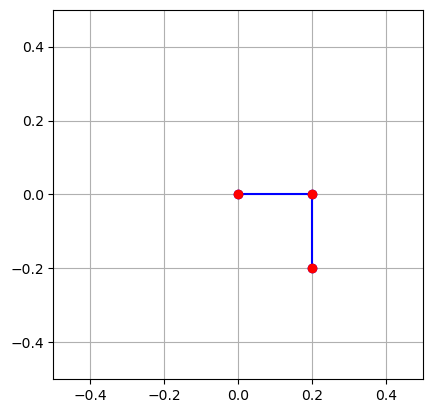

[4.4145, 0.9810000000000002]


Text(0.5, 1.0, 'Señales de torque aplicadas')

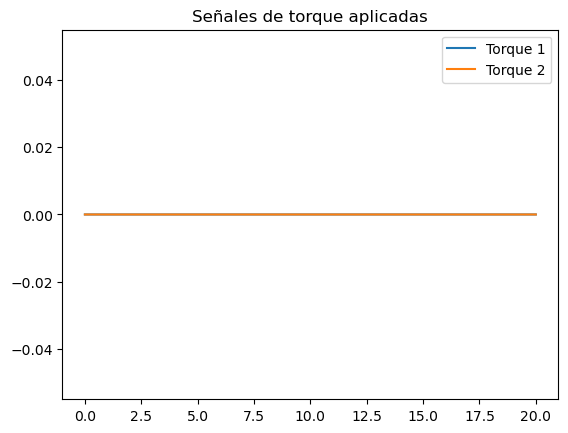

In [8]:
#Definicion inicial del robot
#robot = Robot_2LP(a1=2000, a2=2000, w1=1.5, w2=1, in1=0.016*1e-6,in2=0.0101*1e-6)
robot.show_DH_table()
f_vs = [0,0]
f_ss = [0,0]

# Initial Conditions
initial_tcp_pos = [0.2, -0.2] #No funciona 0,0 y creo que es por la singularidad
initial_tcp_vel = [0.0, 0.0]
initial_tcp_accel = [0.0, 0.0]

robot.set_TCP_position(initial_tcp_pos)
robot.show_DH_table()
robot.show()

vals_dq_t = [0,0]
vals_ddq_t = [0,0]

initial_torques = robot.calculate_inverse_dynamics(vals_dq_t, vals_ddq_t, f_vs , f_ss)
print(initial_torques)

# Initial Configuration
total_time = 20.0  # seconds
time_interval = 0.01 #1.0  # seconds -> Esto esta dando problemas con 0.01, la reduzco a 0.001
num_steps = int(total_time / time_interval)
time = np.linspace(0, total_time, num_steps)
#Todo lo de arriba es necesario SIEMPRE para la simulación


#Define the torques that will be used in the motion
#freq = 0.01*np.pi #90
#torque_1_signal = [10e8*np.sin(2 * np.pi * freq * t) for t in time]
#torque_2_signal = [10e8*np.sin(2 * np.pi * 2*freq * t) for t in time]
const_1 = 0.0#1
const_2 = 0.0#1
torque_1_signal = [const_1*10e8 for t in time]
torque_2_signal = [const_2*10e8 for t in time]
plt.plot(time, torque_1_signal,label='Torque 1')
plt.plot(time, torque_2_signal,label='Torque 2')
plt.legend()
plt.show
plt.title(r'Señales de torque aplicadas')



In [9]:
robot.thetas

[0.0, -1.5707963267948966]

Joint 1 Position: [0.2 0.  0. ]
Joint 2 Position: [ 0.2 -0.2  0. ]


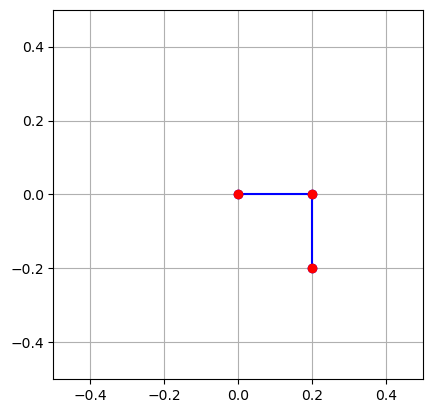

In [10]:
robot.show()

In [11]:
functions = list(robot.forw_dyn_numerical_expr().values())
functions
f1 = functions[0]
f2 = functions[1]



In [12]:
robot.forw_dyn_numerical_expr()

{Derivative(theta1(t), (t, 2)): <function _lambdifygenerated(_Dummy_1063, _Dummy_1064, _Dummy_1065, _Dummy_1066, _Dummy_1067, _Dummy_1068, _Dummy_1069, _Dummy_1070, _Dummy_1071, _Dummy_1072)>,
 Derivative(theta2(t), (t, 2)): <function _lambdifygenerated(_Dummy_1079, _Dummy_1080, _Dummy_1081, _Dummy_1082, _Dummy_1083, _Dummy_1084, _Dummy_1085, _Dummy_1086, _Dummy_1087, _Dummy_1088)>}

In [13]:
x_g1, y_g1 = robot.mass_center_position_self(i=0)  # Pos. centro de masa del eslabon 1 respecto a la terna 1
x_g2, y_g2 = robot.mass_center_position_self(i=1)  # Pos. centro de masa del eslabon 2 respecto a la terna 2

v_I_zz = robot.inertia
v_f_v = [0.0] * robot.num_links
v_f_s = [0.0] * robot.num_links
v_x_g = [x_g1, x_g2]
v_y_g = [y_g1, y_g2]
v_z_g = [0.0, 0.0]
v_sym_q_t = robot.thetas
v_sym_dq_t = [0.0] * robot.num_links
v_theta = robot.thetas

applied_torques = np.matrix([[torque_1_signal[i], torque_2_signal[i]] for i in range(num_steps)])
applied_torques[0]

# Call the lambdified functions stored in the dictionary
#numerical_values = {
#    key: expr(v_I_zz, v_f_v, v_f_s, v_theta, v_x_g, v_y_g, v_z_g, v_sym_q_t, v_sym_dq_t, v_torques)
#    for key, expr in self.num_forward_dynamics.items()
#}

matrix([[0., 0.]])

In [14]:
# Define el sistema de ecuaciones
def system(state, t, torqs, params):
#def system(t, state, torqs, params):
    thetas = state[:2]
    vels = state[2:]
    v_I_zz, v_f_v, v_f_s, v_x_g, v_y_g, v_z_g = params
    v_torques = torqs
    dtheta1_dt = vels[0]
    dtheta2_dt = vels[1]
    dv1_dt = f1(v_I_zz, v_f_v, v_f_s, v_x_g, v_y_g, v_z_g, thetas, thetas, vels, v_torques)
    dv2_dt = f2(v_I_zz, v_f_v, v_f_s, v_x_g, v_y_g, v_z_g, thetas, thetas, vels, v_torques)
    #print(dv1_dt)
    #print(dv2_dt)
    #return np.concatenate([dtheta1_dt, dtheta2_dt, dv1_dt, dv2_dt])
    return [dtheta1_dt, dtheta2_dt, dv1_dt, dv2_dt]


# Vector de tiempo para la integración
#t = np.linspace(0, 10, 1000)  # Desde t=0 hasta t=10 con 1000 puntos
t = np.linspace(0, 10, 10000)
params = (v_I_zz, v_f_v, v_f_s, v_x_g, v_y_g, v_z_g)
initial_conditions = np.concatenate((v_sym_q_t, v_sym_dq_t)).astype(float)
applied_torques = [0.0,0.0]

# Resolver el sistema de ecuaciones
solution = odeint(system, initial_conditions, t, args=(applied_torques, params))

# Extraer las soluciones
theta1_sol = solution[:, 0]
theta2_sol = solution[:, 1]
v1_sol = solution[:, 2]
v2_sol = solution[:, 3]

plt.figure()
plt.plot(t, theta1_sol, label='theta1(t)')
plt.plot(t, theta2_sol, label='theta2(t)')
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.legend()
plt.show()

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2322982189784D-01   r2 =  0.4434578256123D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2322982189784D-01   r2 =  0.4434578256123D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2322982189784D-01   r2 =  0.4434578256123D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2322982189784D-01   r2 =  0.4434578256123D-18


/var/folders/fh/g4nwx4rn28g_fjncv9fq4dyr0000gn/T/ipykernel_91307/677836071.py:26: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(system, initial_conditions, t, args=(applied_torques, params))
/usr/local/anaconda3/lib/python3.12/site-packages/matplotlib/transforms.py:372: RuntimeWarning: overflow encountered in scalar subtract
  return (x0, y0, x1 - x0, y1 - y0)


IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 640x480 with 1 Axes>

In [15]:
solution

array([[ 0.00000000e+00, -1.57079633e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.30799970e-04, -1.57059443e+00, -2.61652676e-01,
         4.03911073e-01],
       [-5.23681461e-04, -1.56998778e+00, -5.24272537e-01,
         8.09752659e-01],
       ...,
       [            nan,             nan,             nan,
                    nan],
       [            nan,             nan,             nan,
                    nan],
       [            nan,             nan,             nan,
                    nan]])

In [16]:
# Define el sistema de ecuaciones
def system(t, state, torqs, params):
    thetas = state[:2]
    vels = state[2:]
    v_I_zz, v_f_v, v_f_s, v_x_g, v_y_g, v_z_g = params
    v_torques = torqs
    dtheta1_dt = vels[0]
    dtheta2_dt = vels[1]
    dv1_dt = f1(v_I_zz, v_f_v, v_f_s, v_x_g, v_y_g, v_z_g, thetas, thetas, vels, v_torques)
    dv2_dt = f2(v_I_zz, v_f_v, v_f_s, v_x_g, v_y_g, v_z_g, thetas, thetas, vels, v_torques)
    #print(dv1_dt)
    #print(dv2_dt)
    #return np.concatenate([dtheta1_dt, dtheta2_dt, dv1_dt, dv2_dt])
    return [dtheta1_dt, dtheta2_dt, dv1_dt, dv2_dt]


# Vector de tiempo para la integración
params = (v_I_zz, v_f_v, v_f_s, v_x_g, v_y_g, v_z_g)
initial_conditions = np.concatenate((v_sym_q_t, v_sym_dq_t))#.astype(float)
applied_torques = [0,0]

# Resolver el sistema de ecuaciones
t_span = (0, 5)  # Desde t=0 hasta t=10
t_eval = np.linspace(0, 5, 1000)  # 100 puntos de tiempo igualmente espaciados entre 0 y 10
solution = solve_ivp(system, t_span, initial_conditions, args=(applied_torques, params), method='LSODA', rtol=1e-8, atol=1e-8)
#solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval ,args=(applied_torques, params), method='RK45', rtol=1e-12, atol=1e-12)


# Extraer las soluciones
theta1_sol = solution.y[0]
theta2_sol = solution.y[1]
v1_sol = solution.y[2]
v2_sol = solution.y[3]
sol_time = solution.t


plt.figure()
plt.plot(sol_time, theta1_sol, label='theta1(t)')
plt.plot(sol_time, theta2_sol, label='theta2(t)')
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.legend()
plt.show()

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2322982278826D-01   r2 =  0.9326486577990D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2322982278826D-01   r2 =  0.9326486577990D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2322982278826D-01   r2 =  0.9326486577990D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2322982278826D-01   r2 =  0.9326486577990D-18
 lsoda--  warning..internal t (=r1) 

In [ ]:
thetas_pos = [[theta1_sol[i], theta2_sol[i]] for i in range(len(theta1_sol))]
#np.matrix([[theta1_sol[i], theta2_sol[i]] for i in range(len(theta1_sol))]) #np.array(theta1_sol,theta2_sol)
thetas_pos
robot.show_animation(thetas_pos[:300],300)

In [ ]:
applied_torques = np.matrix([[torque_1_signal[i], torque_2_signal[i]] for i in range(num_steps)])
applied_torques[0]

matrix([[0., 0.]])

Joint 1 Position: [0.2 0.  0. ]
Joint 2 Position: [ 0.2 -0.2  0. ]


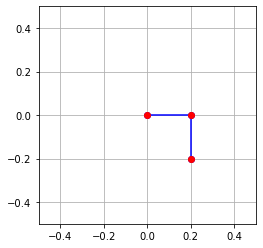

0
0.0
[0.0, 0.0]
[0.0, -1.5707963267948966]
[0.0, 0.0]
[-63.35149235  69.06067093]
[0.0, -1.5707963267948966]
[0.6335149235118056, -0.6906067093448616]
1
0.01
[0.0, 0.0]
[0.0, -1.5707963267948966]
[0.6335149235118056, -0.6906067093448616]
[-63.5757929   69.75530115]
[-0.006335149235118056, -1.563890259701448]
[1.2692728525388075, -1.3881597208336776]
2
0.02
[0.0, 0.0]
[-0.006335149235118056, -1.563890259701448]
[1.2692728525388075, -1.3881597208336776]
[-64.26729134  71.88057124]
[-0.019027877760506132, -1.550008662493111]
[1.9119457659398018, -2.1069654332813363]
3
0.03
[0.0, 0.0]
[-0.019027877760506132, -1.550008662493111]
[1.9119457659398018, -2.1069654332813363]
[-65.51242046  75.62859896]
[-0.03814733541990415, -1.5289390081602978]
[2.567069970540781, -2.863251422849113]
4
0.04
[0.0, 0.0]
[-0.03814733541990415, -1.5289390081602978]
[2.567069970540781, -2.863251422849113]
[-67.49080028  81.39787322]
[-0.06381803512531196, -1.5003064939318067]
[3.2419779733801946, -3.67723015504915]

OverflowError: (34, 'Result too large')

In [ ]:
# Main Simulation Loop
step = 0
accumulated_time = 0.0
num_steps = applied_torques.shape[0]  # Number of time steps


#Condiciones Iniciales:
actual_j_pos = robot.thetas
actual_j_vels = [0.0,0.0]
#actual_torques = [0.0, 0.0]


robot.show()

new_torques = []
new_j_pos = []
new_j_vels = []
new_j_accs = []
time_vector = [0]



while accumulated_time < total_time and step < num_steps:
    # Get torques for the current time step
    #actual_torques = [x + y for x, y in zip(actual_torques, [torque_1_signal[step],torque_2_signal[step]])]
    actual_torques = [torque_1_signal[step], torque_2_signal[step]]

    actual_j_accs = robot.forward_dynamics(actual_j_vels, actual_torques)

    next_j_pos, next_j_vels =  robot.integrate_dynamics(actual_j_pos, actual_j_vels, actual_j_accs, time_interval)

    # Data Logging (if necessary)
    time_vector.append(accumulated_time)
    new_torques.append(actual_torques)
    new_j_pos.append(actual_j_pos)
    new_j_vels.append(actual_j_vels)
    new_j_accs.append(actual_j_accs)

    print(step)
    print(accumulated_time)
    print(actual_torques)
    print(actual_j_pos)
    print(actual_j_vels)
    print(actual_j_accs)
    print(next_j_pos)
    print(next_j_vels)

    # Update accumulated time and step
    actual_j_pos = next_j_pos
    actual_j_vels = next_j_vels
    accumulated_time += time_interval
    step += 1

    # Pause to simulate real-time execution
    #pytime.sleep(time_interval)

# End of Simulation 


In [ ]:
#actual_torques
print(new_j_accs[0])
print(new_j_accs[-1])

print(new_j_vels[0])
print(new_j_vels[-1])

In [ ]:
robot.calculate_forward_dynamics(actual_j_vels, actual_torques, f_vs, f_ss)

In [ ]:
accelerations = robot.calculate_forward_dynamics(vals_dq_t, actual_torques, f_vs, f_ss)

In [ ]:
actual_pos, actual_orient = robot.calculate_TCP_kinematics()
print(actual_pos)

In [ ]:
#nombre_archivo = f'/content/drive/MyDrive/CT_p/2lpr_sin_{freq}_{total_time}_{num_steps}_{a_actual}.csv'
nombre_archivo = f'./2lpr_const_{const_1}_{const_2}_{total_time}_{num_steps}_{fecha_actual}.csv'

In [ ]:
cantidad = num_steps

In [ ]:
if not os.path.isfile(nombre_archivo) or os.path.getsize(nombre_archivo) == 0:
    # Si el archivo no existe o está vacío, escribir las cabeceras CSV
    with open(nombre_archivo, 'w') as archivo:
        archivo.write('ID, Time, Theta_1, Theta_2, D_Theta_1, D_Theta_2, DD_Theta_1, DD_Theta_2, Torque_1, Torque_2\n')
with open(nombre_archivo, 'a') as archivo:
    for _ in range(cantidad):
        id = _ +1
        time = time_vector[_]
        j_1 = new_j_pos[_][0]
        j_2 = new_j_pos[_][1]
        d_j_1 = new_j_vels[_][0]
        d_j_2 = new_j_vels[_][1]
        dd_j_1 = new_j_accs[_][0]
        dd_j_2 = new_j_accs[_][1]
        theta_1 = new_torques[_][0]
        theta_2 = new_torques[_][1]
        archivo.write(f'{id}, {time}, {j_1}, {j_2}, {d_j_1}, {d_j_2}, {dd_j_1}, {dd_j_2}, {theta_1}, {theta_2}\n')

In [ ]:
robot.show_animation(new_j_pos[:300],300)

**Referencias:**

[Simulador 3LM con uso de NN](https://github.com/adinarad/IK-3LinkManipulator-NN/blob/master/src/main.ipynb)

[Pyro](https://github.com/SherbyRobotics/pyro)

[ESE446: Robotics Dynamics and Control Final Project](https://ajboloor.github.io/3link-planar-robot/)

[Dynamic parameter identification of parallel robots starting from the measurement of joints position and forces ](https://ve.scielo.org/scielo.php?script=sci_arttext&pid=S0254-07702009000200004)

[Modelo Dinámico del Doble Péndulo](https://drive.google.com/drive/u/0/folders/14-C1Pc6NoQLiYuo1enKQOHwc31hwpLBT)

[Matplotlib - The double pendulum problem](https://matplotlib.org/stable/gallery/animation/double_pendulum.html)

[Velocity of 2-Joint Planar Robot Arm](https://robotacademy.net.au/lesson/velocity-of-2-joint-planar-robot-arm/)

[Lentitud de cálculo de la inversa](https://stackoverflow.com/questions/75553096/why-is-sympy-matrix-inv-slow)

[A Python Project for Lagrangian Mechanics (codigo compilado)](https://code.google.com/archive/p/euler-lagrange-dynamics/downloads)